## Install Requirements

In [2]:
# ! pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1
# ! pip install diffusers
# ! pip install matplotlib

In [3]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

/Users/wenbo/anaconda3/envs/DiffusionModel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [4]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

In [5]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 5, 6, 5, 7, 4, 5, 6])


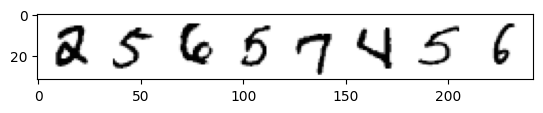

In [6]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)


# images = x.squeeze(1)  # Shape becomes [8, 28, 28]
# # Plot each image
# batch_size = images.shape[0]
# for i in range(batch_size):
#     plt.subplot(1, batch_size, i + 1)
#     plt.imshow(images[i].cpu().numpy())  # Convert to numpy and specify grayscale
#     plt.axis('off')  # Optional: Turn off axis for cleaner display


plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [7]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])


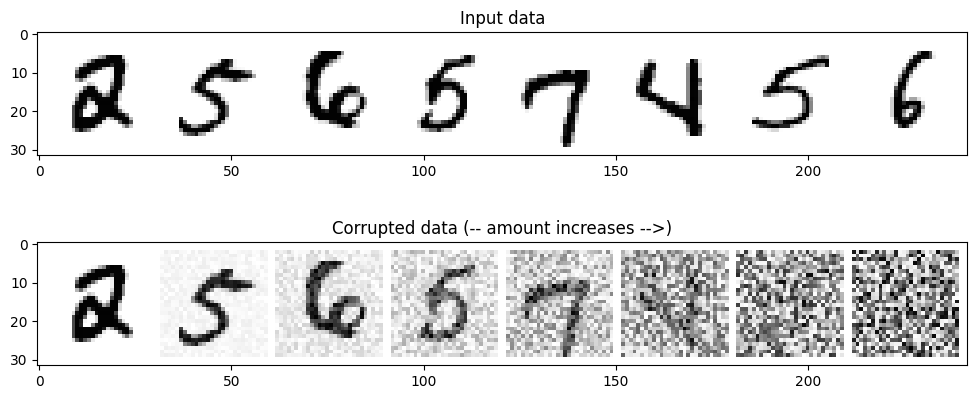

In [8]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
print(amount)
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [9]:
# class BasicUNet(nn.Module):
#     """A minimal UNet implementation."""

#     def __init__(self, in_channels=1, out_channels=1):
#         super().__init__()
#         self.down_layers = torch.nn.ModuleList(
#             [
#                 nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
#                 nn.Conv2d(32, 64, kernel_size=5, padding=2),
#                 nn.Conv2d(64, 64, kernel_size=5, padding=2),
#             ]
#         )
#         self.up_layers = torch.nn.ModuleList(
#             [
#                 nn.Conv2d(64, 64, kernel_size=5, padding=2),
#                 nn.Conv2d(64, 32, kernel_size=5, padding=2),
#                 nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
#             ]
#         )
#         self.act = nn.SiLU()  # The activation function
#         self.downscale = nn.MaxPool2d(2)
#         self.upscale = nn.Upsample(scale_factor=2)

#     def forward(self, x):
#         h = []
#         for i, l in enumerate(self.down_layers):
#             x = self.act(l(x))  # Through the layer and the activation function
#             if i < 2:  # For all but the third (final) down layer:
#                 h.append(x)  # Storing output for skip connection
#                 x = self.downscale(x)  # Downscale ready for the next layer

#         for i, l in enumerate(self.up_layers):
#             if i > 0:  # For all except the first up layer
#                 x = self.upscale(x)  # Upscale
#                 x += h.pop()  # Fetching stored output (skip connection)
#             x = self.act(l(x))  # Through the layer and the activation function

#         return x


class BasicUNet(nn.Module):
    """A minimal UNet implementation with more down and up layers."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 128, kernel_size=5, padding=2),
                nn.Conv2d(128, 128, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(128, 128, kernel_size=5, padding=2),
                nn.Conv2d(128 + 128, 64, kernel_size=5, padding=2),  # Note: Add channel from skip connection
                nn.Conv2d(64 + 64, 32, kernel_size=5, padding=2),    # Add channel from skip connection
                nn.Conv2d(32 + 32, out_channels, kernel_size=5, padding=2),  # Add channel from skip connection
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        
        # Use Upsample with align_corners=True
        self.upscale = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        h = []  # Store skip connections
        
        # Down layers
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Apply convolution + activation
            if i < len(self.down_layers) - 1:  # For all but the last down layer
                h.append(x)  # Store output for skip connection
                x = self.downscale(x)  # Downscale for the next layer

        # Up layers
        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upsample
                # Ensure sizes are aligned for concatenation
                if x.shape[2:] != h[-1].shape[2:]:
                    x = torch.nn.functional.interpolate(x, size=h[-1].shape[2:], mode='bilinear', align_corners=True)
                x = torch.cat([x, h.pop()], dim=1)  # Concatenate skip connection
            x = self.act(l(x))  # Apply convolution + activation

        return x



In [10]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [11]:
sum([p.numel() for p in net.parameters()])

1590177

Finished epoch 0. Average loss for this epoch: 0.027375
Finished epoch 1. Average loss for this epoch: 0.020804
Finished epoch 2. Average loss for this epoch: 0.018639
Finished epoch 3. Average loss for this epoch: 0.017969


(0.0, 0.1)

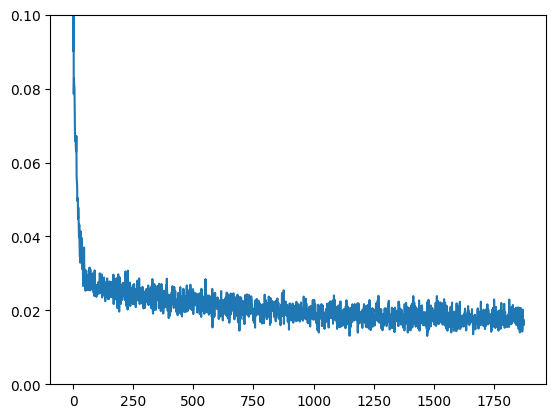

In [12]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 4

# Create the network
net = BasicUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

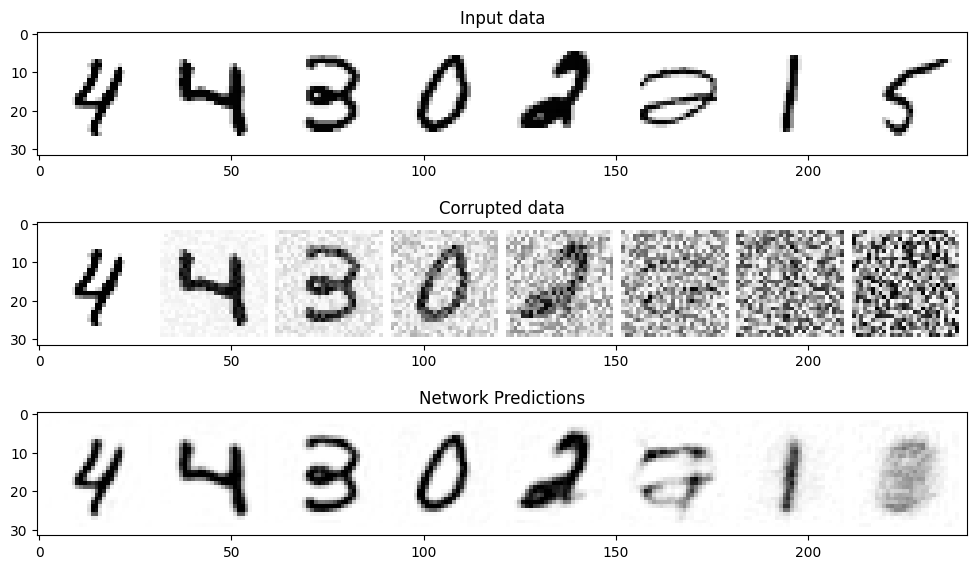

In [13]:
# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

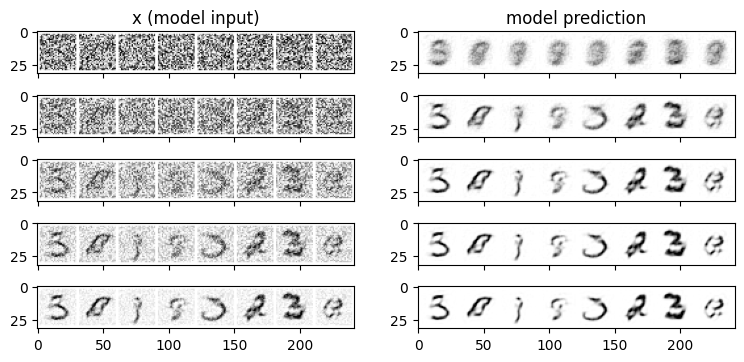

In [14]:
# @markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

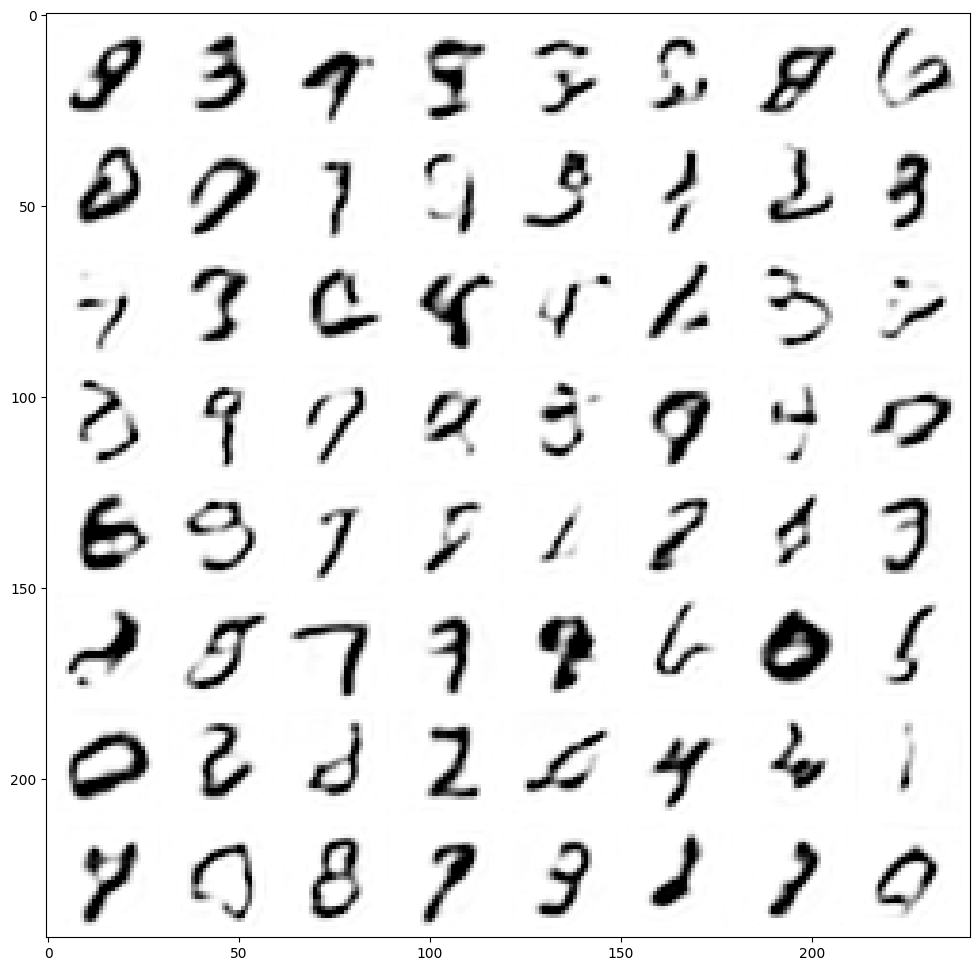

In [15]:
# @markdown Showing more results, using 40 sampling steps
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")

In [16]:
model = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [17]:
sum([p.numel() for p in model.parameters()])  # 1.7M vs the ~309k parameters of the BasicUNet

1707009

Finished epoch 0. Average loss for this epoch: 0.020635
Finished epoch 1. Average loss for this epoch: 0.012872
Finished epoch 2. Average loss for this epoch: 0.011640


Text(0.5, 1.0, 'Generated Samples')

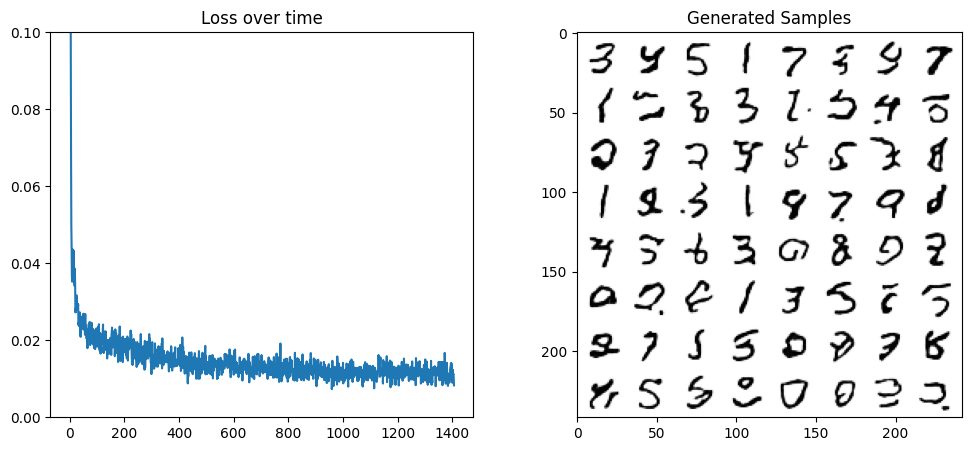

In [18]:
# @markdown Trying UNet2DModel instead of BasicUNet:

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)  # <<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample  # <<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")

Text(0.5, 1.0, 'Loss over time')

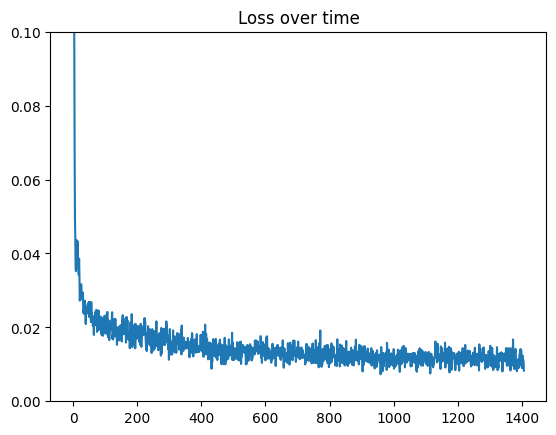

In [35]:
plt.plot(losses)
plt.ylim(0, 0.1)
plt.title("Loss over time")

Text(0.5, 1.0, 'Generated Samples')

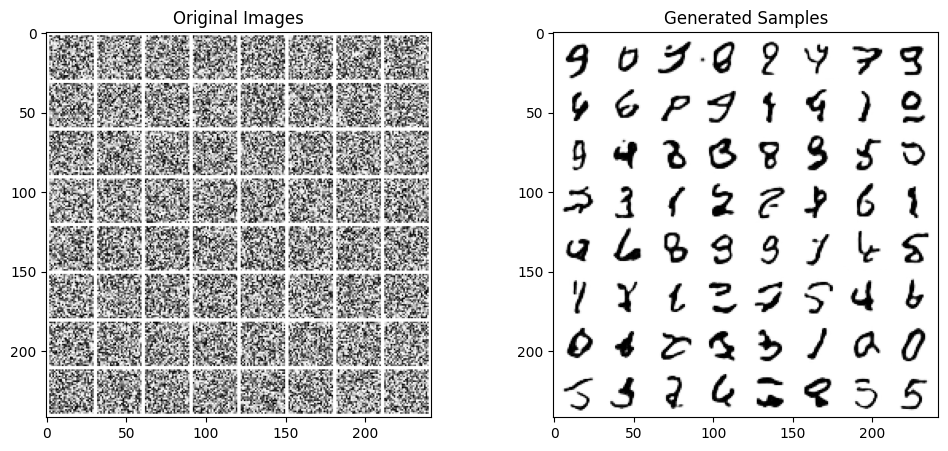

In [42]:
n_steps = 60


x = torch.rand(64, 1, 28, 28)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Correct the channel handling for imshow
# img = torchvision.utils.make_grid(x, nrow=8)  # Make a grid of images
# axs[0].imshow(img.permute(1, 2, 0).squeeze(), cmap="Greys")  # Convert from [C, H, W] to [H, W]
axs[0].imshow(torchvision.utils.make_grid(x.detach(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[0].set_title("Original Images")


x = x.to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Generated Samples")

## Timestep Does not make any changes since we only trained it with step=0

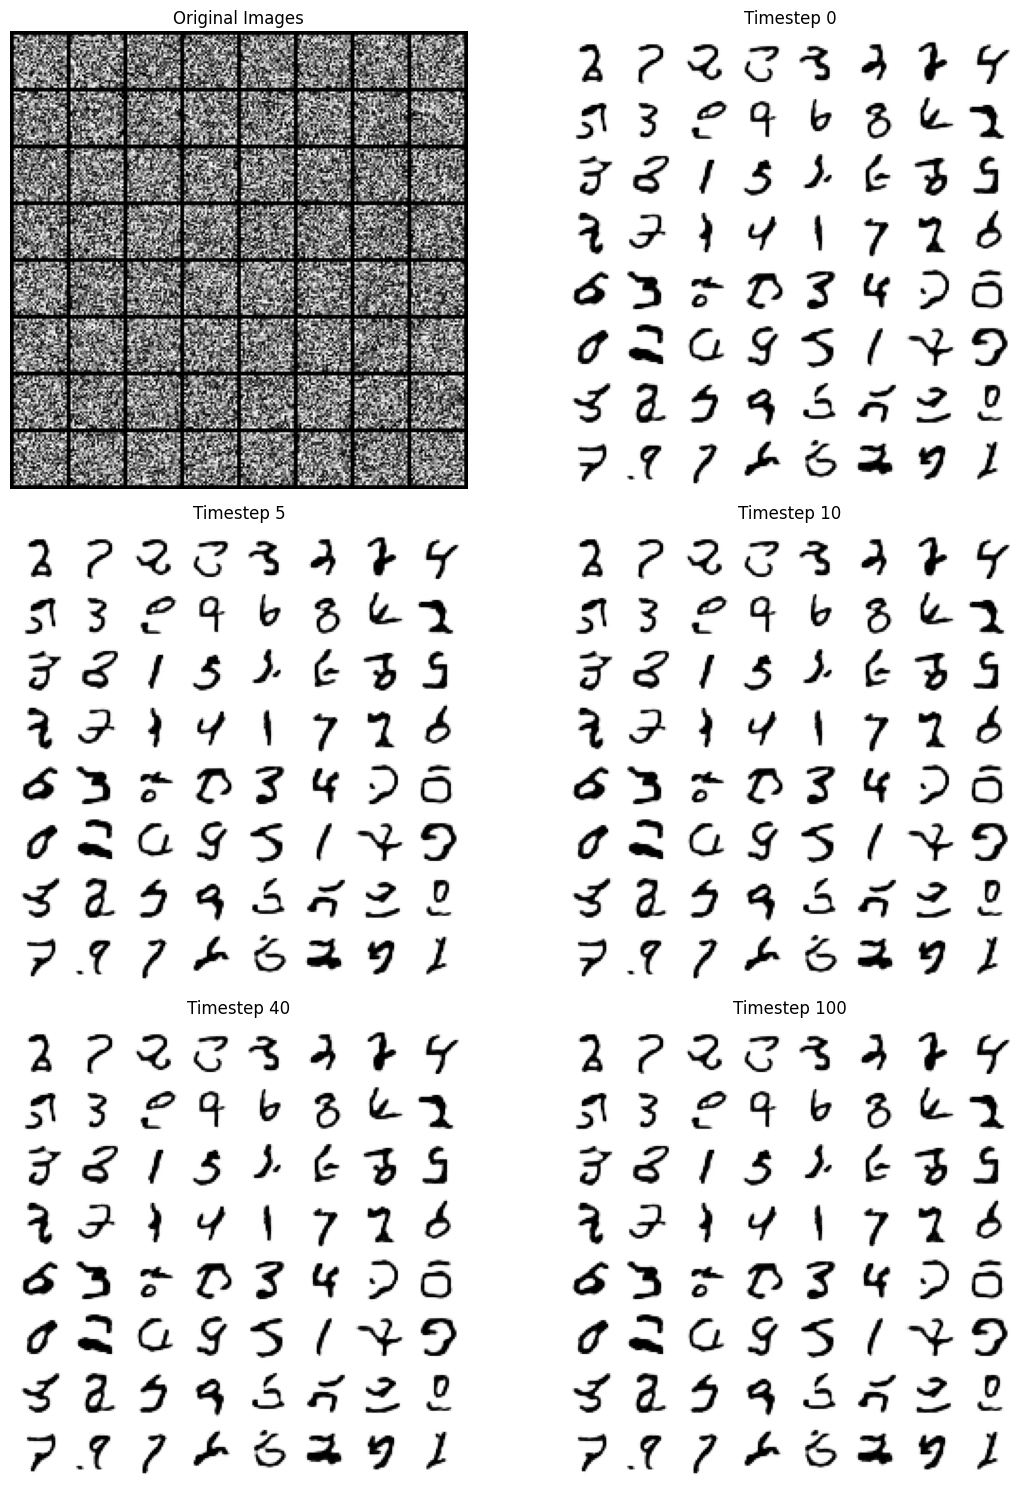

In [41]:
# n_steps = 60


# x_orig = torch.rand(64, 1, 28, 28)
# fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# # Correct the channel handling for imshow
# img = torchvision.utils.make_grid(x_orig, nrow=8)  # Make a grid of images
# axs[0].imshow(img.permute(1, 2, 0).squeeze(), cmap="Greys")  # Convert from [C, H, W] to [H, W]
# axs[0].set_title("Original Images")


# x = x_orig.to(device)
# timesteps = [0, 5, 10, 20, 40, 100]

# for timestep_index in range(0, timesteps):
#     for i in range(n_steps):
#         noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
#         with torch.no_grad():
#             pred = net(x, timesteps[timestep_index]).sample
#         mix_factor = 1 / (n_steps - i)
#         x = x * (1 - mix_factor) + pred * mix_factor
#     axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
#     axs[1].set_title("Generated Samples")


# Number of steps and timesteps to visualize
n_steps = 60
timesteps = [0, 5, 10, 40, 100]

# Generate random batch of 64 grayscale images (N, C, H, W)
x_orig = torch.rand(64, 1, 28, 28)

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 15))  # 3 rows, 2 columns

# Display the original images in the first plot
# img = torchvision.utils.make_grid(x_orig, nrow=8)  # Make a grid of images
axs[0, 0].imshow(torchvision.utils.make_grid(x.detach(), nrow=8)[0].clip(0, 1), cmap="Greys")  # Convert from [C, H, W] to [H, W]
axs[0, 0].set_title("Original Images")
axs[0, 0].axis('off')  # Remove axis for clean display

# Remove second plot in the first row (already occupied by the original image)
# axs[0, 1] will now be used for Timestep 0

# Loop over each timestep
for idx, timestep in enumerate(timesteps):
    # Reset x to original images for each timestep
    x = x_orig.to(device)
    for i in range(n_steps):
        noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
        with torch.no_grad():
            pred = net(x, timestep).sample  # Ensure that `net(x, timestep)` returns an object with a `.sample` attribute
        mix_factor = 1 / (n_steps - i)
        x = x * (1 - mix_factor) + pred * mix_factor

    # Calculate 2D subplot index for each image, but shift by 1 because (0,0) is already taken
    row, col = divmod(idx + 1, 2)  # Start from (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)
    # img = torchvision.utils.make_grid(x.detach().cpu(), nrow=8)  # Make a grid of images
    axs[row, col].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")
    axs[row, col].set_title(f"Timestep {timestep}")
    axs[row, col].axis('off')  # Remove axis for clean display

# Display the plots
plt.tight_layout()
plt.show()


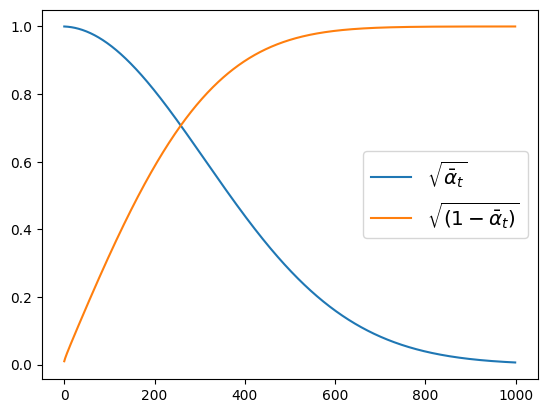

In [34]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")